# <font size="5">Libraries Imported:</font>
* <font size="4">**pandas:** Library for data manipulation and analysis using DataFrames.</font>
* <font size="4">**sklearn:** Machine learning library for data preprocessing, model selection, and evaluation.</font>
* <font size="4">**matplotlib.pyplot:** Create static and interactive visualizations.</font>
* <font size="4">**seaborn:** Statistical data visualization library based on matplotlib.</font>
* <font size="4">**lightgbm:** Gradient boosting framework using tree-based learning algorithms, designed for efficiency and scalability.</font>
* <font size="4">**xgboost:** Optimized gradient boosting library.</font>
* <font size="4">**sklearn.ensemble.ExtraTreesRegressor:** Fit multiple randomized trees, average results.</font>

In [1]:
import warnings
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import ExtraTreesRegressor
warnings.filterwarnings('ignore')

# <font size="5">Loading the Dataset</font>

In [2]:
data = pd.read_csv(
    '/kaggle/input/australian-vehicle-prices/Australian Vehicle Prices.csv',
    na_values=['POA', '-', '- / -'],
)

data.head()

,Brand,Year,Model,Car/Suv,Title,UsedOrNew,Transmission,Engine,DriveType,FuelType,FuelConsumption,Kilometres,ColourExtInt,Location,CylindersinEngine,BodyType,Doors,Seats,Price
0,Ssangyong,2022.0,Rexton,Sutherland Isuzu Ute,2022 Ssangyong Rexton Ultimate (awd),DEMO,Automatic,"4 cyl, 2.2 L",AWD,Diesel,8.7 L / 100 km,5595.0,White / Black,"Caringbah, NSW",4 cyl,SUV,4 Doors,7 Seats,51990.0
1,MG,2022.0,MG3,Hatchback,2022 MG MG3 Auto Excite (with Navigation),USED,Automatic,"4 cyl, 1.5 L",Front,Premium,6.7 L / 100 km,16.0,Black / Black,"Brookvale, NSW",4 cyl,Hatchback,5 Doors,5 Seats,19990.0
2,BMW,2022.0,430I,Coupe,2022 BMW 430I M Sport,USED,Automatic,"4 cyl, 2 L",Rear,Premium,6.6 L / 100 km,8472.0,Grey / White,"Sylvania, NSW",4 cyl,Coupe,2 Doors,4 Seats,108988.0
3,Mercedes-Benz,2011.0,E500,Coupe,2011 Mercedes-Benz E500 Elegance,USED,Automatic,"8 cyl, 5.5 L",Rear,Premium,11 L / 100 km,136517.0,White / Brown,"Mount Druitt, NSW",8 cyl,Coupe,2 Doors,4 Seats,32990.0
4,Renault,2022.0,Arkana,SUV,2022 Renault Arkana Intens,USED,Automatic,"4 cyl, 1.3 L",Front,Unleaded,6 L / 100 km,1035.0,Grey / Black,"Castle Hill, NSW",4 cyl,SUV,4 Doors,5 Seats,34990.0


# <font size="5">Extracting Numerical Values</font>

In [3]:
# Helper function to extraUnique Values and Missing Valuesct numbers from string columns
def extract_number(data: 'pd.DataFrame',
                  col: 'str',
                  pattern: 'str') -> 'pd.Series':
    '''
    Extracts a number using the given regex pattern from the given data and col,
    converts the result to float, and returns the result as a pd.Series.
    '''
    return data[col].str.extract(pattern, expand=False).astype('float32')

In [4]:
# We use the previous hepler function to extract numbers from string columns
data['Engine'] = extract_number(data, col='Engine', pattern=r'.*?(\d+\.?\d*) L')
data['FuelConsumption'] = extract_number(data, col='FuelConsumption', pattern=r'(\d+\.?\d*) L.*')
data['CylindersinEngine'] = extract_number(data, col='CylindersinEngine', pattern=r'(\d+) (?:cyl|L)')
data['Doors'] = extract_number(data, col='Doors', pattern=r'(\d+) Doors')
data['Seats'] = extract_number(data, col='Seats', pattern=r'(\d+) Seats')

data.head()

,Brand,Year,Model,Car/Suv,Title,UsedOrNew,Transmission,Engine,DriveType,FuelType,FuelConsumption,Kilometres,ColourExtInt,Location,CylindersinEngine,BodyType,Doors,Seats,Price
0,Ssangyong,2022.0,Rexton,Sutherland Isuzu Ute,2022 Ssangyong Rexton Ultimate (awd),DEMO,Automatic,2.2,AWD,Diesel,8.7,5595.0,White / Black,"Caringbah, NSW",4.0,SUV,4.0,7.0,51990.0
1,MG,2022.0,MG3,Hatchback,2022 MG MG3 Auto Excite (with Navigation),USED,Automatic,1.5,Front,Premium,6.7,16.0,Black / Black,"Brookvale, NSW",4.0,Hatchback,5.0,5.0,19990.0
2,BMW,2022.0,430I,Coupe,2022 BMW 430I M Sport,USED,Automatic,2.0,Rear,Premium,6.6,8472.0,Grey / White,"Sylvania, NSW",4.0,Coupe,2.0,4.0,108988.0
3,Mercedes-Benz,2011.0,E500,Coupe,2011 Mercedes-Benz E500 Elegance,USED,Automatic,5.5,Rear,Premium,11.0,136517.0,White / Brown,"Mount Druitt, NSW",8.0,Coupe,2.0,4.0,32990.0
4,Renault,2022.0,Arkana,SUV,2022 Renault Arkana Intens,USED,Automatic,1.3,Front,Unleaded,6.0,1035.0,Grey / Black,"Castle Hill, NSW",4.0,SUV,4.0,5.0,34990.0


In [5]:
# How many samples and features does this dataset contain?
data.describe()

,Year,Engine,FuelConsumption,Kilometres,CylindersinEngine,Doors,Seats,Price
count,16733.000000,15058.000000,15036.000000,16142.000000,15059.000000,15059.000000,15029.000000,1.668100e+04
mean,2016.229248,2.403307,7.663661,100096.109714,4.423601,4.005047,5.101404,3.730333e+04
std,5.247705,0.923092,2.324609,78213.114589,1.120655,0.693097,1.119178,3.717787e+04
min,1940.000000,0.000000,0.000000,1.000000,0.000000,2.000000,2.000000,8.800000e+01
25%,2013.000000,2.000000,6.500000,40757.000000,4.000000,4.000000,5.000000,1.899900e+04
50%,2017.000000,2.200000,7.600000,85951.500000,4.000000,4.000000,5.000000,2.950000e+04
75%,2020.000000,2.800000,8.800000,146544.500000,4.000000,4.000000,5.000000,4.399000e+04
max,2023.000000,9.800000,27.000000,533849.000000,12.000000,5.000000,22.000000,1.500000e+06


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16734 entries, 0 to 16733
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Brand              16733 non-null  object 
 1   Year               16733 non-null  float64
 2   Model              16733 non-null  object 
 3   Car/Suv            16706 non-null  object 
 4   Title              16733 non-null  object 
 5   UsedOrNew          16733 non-null  object 
 6   Transmission       16482 non-null  object 
 7   Engine             15058 non-null  float32
 8   DriveType          16733 non-null  object 
 9   FuelType           16096 non-null  object 
 10  FuelConsumption    15036 non-null  float32
 11  Kilometres         16142 non-null  float64
 12  ColourExtInt       16374 non-null  object 
 13  Location           16284 non-null  object 
 14  CylindersinEngine  15059 non-null  float32
 15  BodyType           16452 non-null  object 
 16  Doors              150

# <font size="5">Identifying Unique Values and Missing Values</font>

In [7]:
for i in data.columns:
    print(i, len(data[i].unique()))

Brand 77
Year 46
Model 782
Car/Suv 619
Title 8805
UsedOrNew 4
Transmission 3
Engine 66
DriveType 6
FuelType 9
FuelConsumption 157
Kilometres 14261
ColourExtInt 834
Location 619
CylindersinEngine 10
BodyType 11
Doors 5
Seats 14
Price 3794


In [8]:
data.isnull().sum()

Brand                   1
Year                    1
Model                   1
Car/Suv                28
Title                   1
UsedOrNew               1
Transmission          252
Engine               1676
DriveType               1
FuelType              638
FuelConsumption      1698
Kilometres            592
ColourExtInt          360
Location              450
CylindersinEngine    1675
BodyType              282
Doors                1675
Seats                1705
Price                  53
dtype: int64

# <font size="5">Removing Missing Values by filtering out the rows</font>

In [9]:
data = data[data['Price'].isna() == False]  #include rows where 'Price' is not NaN

In [10]:
data.isna().sum() & data['Engine'].isna().sum()

Brand                   0
Year                    0
Model                   0
Car/Suv                26
Title                   0
UsedOrNew               0
Transmission          115
Engine               1659
DriveType               0
FuelType              632
FuelConsumption      1553
Kilometres            571
ColourExtInt           96
Location               65
CylindersinEngine    1658
BodyType               19
Doors                1658
Seats                1560
Price                   0
dtype: int64

In [11]:
data = data[data['Engine'].isna() == False]

In [12]:
data.isnull().sum()

Brand                  0
Year                   0
Model                  0
Car/Suv               13
Title                  0
UsedOrNew              0
Transmission          44
Engine                 0
DriveType              0
FuelType             230
FuelConsumption       23
Kilometres           546
ColourExtInt         323
Location             449
CylindersinEngine      0
BodyType               0
Doors                  0
Seats                 30
Price                  0
dtype: int64

# <font size="5">KNN Imputation for Kilometres</font>

In [13]:
def impute_km(df):
    copy = df.copy()

    transform = ["Kilometres"]

    imputer = KNNImputer(n_neighbors=5)
    scaler = StandardScaler()
    le = LabelEncoder()

    for col in copy.columns: 
        if copy[col].dtype == "object":
            copy[col] = le.fit_transform(copy[col].astype(str)) #label encoding

    copy_scaled = scaler.fit_transform(copy.drop(columns=transform))
    copy_scaled_df = pd.DataFrame(copy_scaled, columns=copy.drop(columns=transform).columns)

    copy_scaled_df.reset_index(drop=True, inplace=True)
    train_transform = df[transform].reset_index(drop=True)

    copy = pd.concat([copy_scaled_df, train_transform], axis=1) #concatenating

    copy_transform = imputer.fit_transform(copy)
    copy = pd.DataFrame(copy_transform, columns=copy.columns)

    df[transform] = copy[transform]
    return df

In [14]:
data = impute_km(data)

# <font size="5">Impute Missing Values with Mode</font>

In [15]:
columns_to_impute = [
    'Car/Suv', 'Transmission', 'FuelType', 'FuelConsumption', 
    'Kilometres', 'ColourExtInt', 'Location', 'Seats'
]

for column in columns_to_impute:
    mode_value = data[column].mode()[0]   #replacing Nan values with mode 
    data[column].fillna(mode_value, inplace=True)

In [16]:
for i in data.columns:
    print(i, len(data[i].unique()))

Brand 70
Year 40
Model 694
Car/Suv 242
Title 7469
UsedOrNew 3
Transmission 2
Engine 65
DriveType 5
FuelType 8
FuelConsumption 156
Kilometres 12119
ColourExtInt 737
Location 595
CylindersinEngine 9
BodyType 10
Doors 4
Seats 13
Price 3564


# <font size="5">One-Hot Encoding</font>

In [17]:
ohe = ['UsedOrNew', 'DriveType', 'Doors']
ohe_binary = ['Transmission']
data = pd.get_dummies(data, columns=ohe)
data = pd.get_dummies(data, columns=ohe_binary, drop_first=True)

# <font size="5">Label Encoding</font>

In [18]:
le = LabelEncoder()
for i in data.columns:
    if data[i].dtype == "object":
        data[i] = le.fit_transform(data[i])

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15022 entries, 0 to 16733
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Brand                15022 non-null  int64  
 1   Year                 15022 non-null  float64
 2   Model                15022 non-null  int64  
 3   Car/Suv              15022 non-null  int64  
 4   Title                15022 non-null  int64  
 5   Engine               15022 non-null  float32
 6   FuelType             15022 non-null  int64  
 7   FuelConsumption      15022 non-null  float32
 8   Kilometres           15022 non-null  float64
 9   ColourExtInt         15022 non-null  int64  
 10  Location             15022 non-null  int64  
 11  CylindersinEngine    15022 non-null  float32
 12  BodyType             15022 non-null  int64  
 13  Seats                15022 non-null  float32
 14  Price                15022 non-null  float64
 15  UsedOrNew_DEMO       15022 non-null  bool

# <font size="5">Correlation Analysis</font>

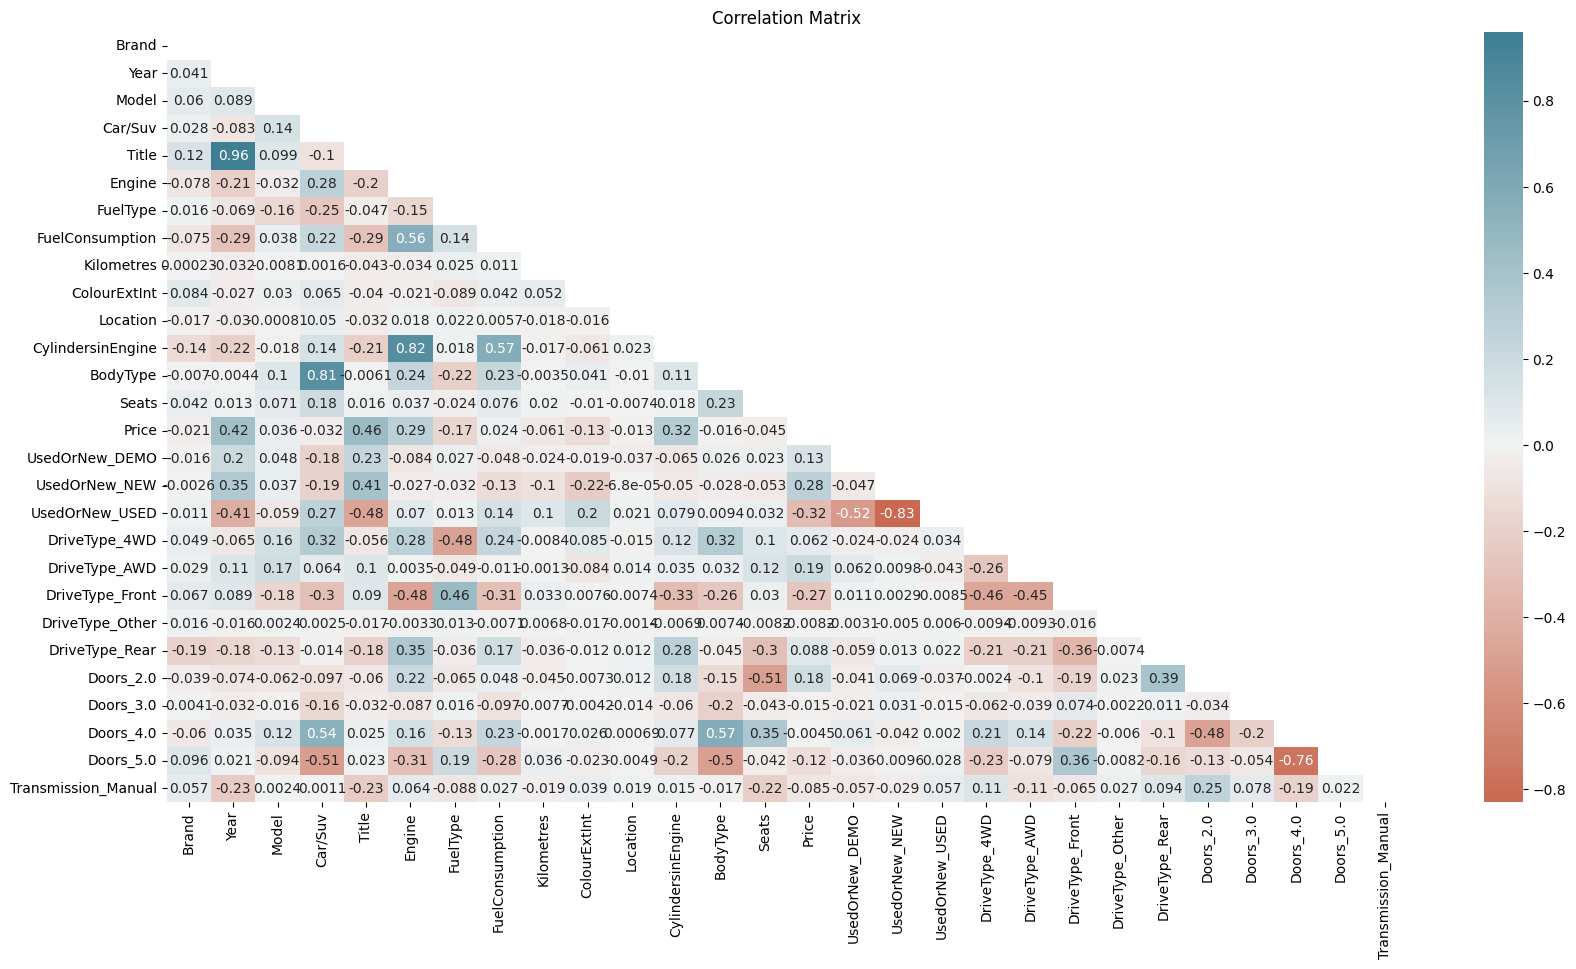

Top 3 features highly correlated with 'Price' are: Title Year CylindersinEngine



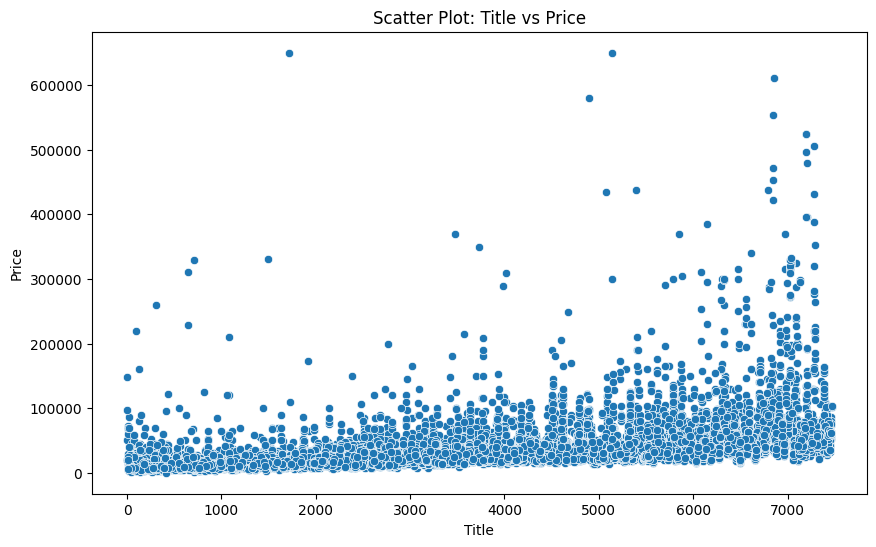

Observation for Title: The correlation between Title and 'Price' suggests that certain titles are associated with higher or lower prices, reflecting brand or model value.


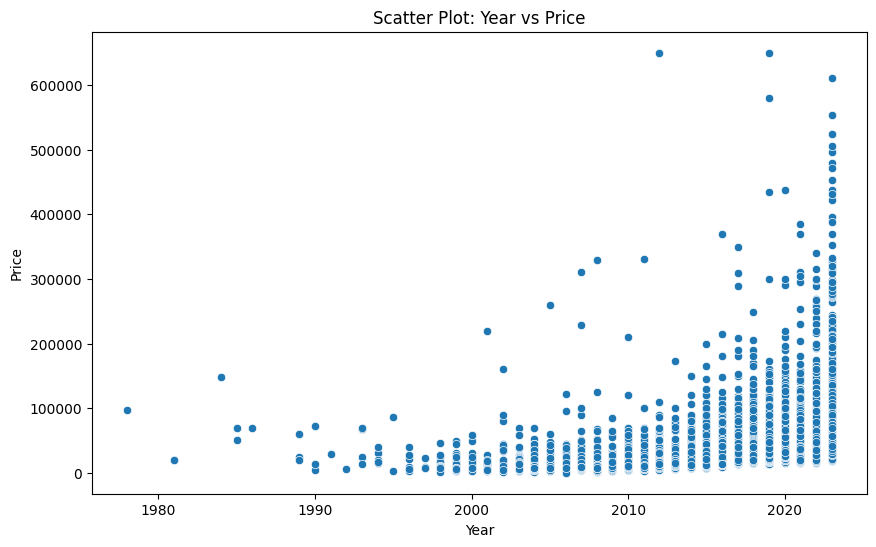

Observation for Year: As Year increases, 'Price' tends to increase, indicating that newer cars are priced higher.


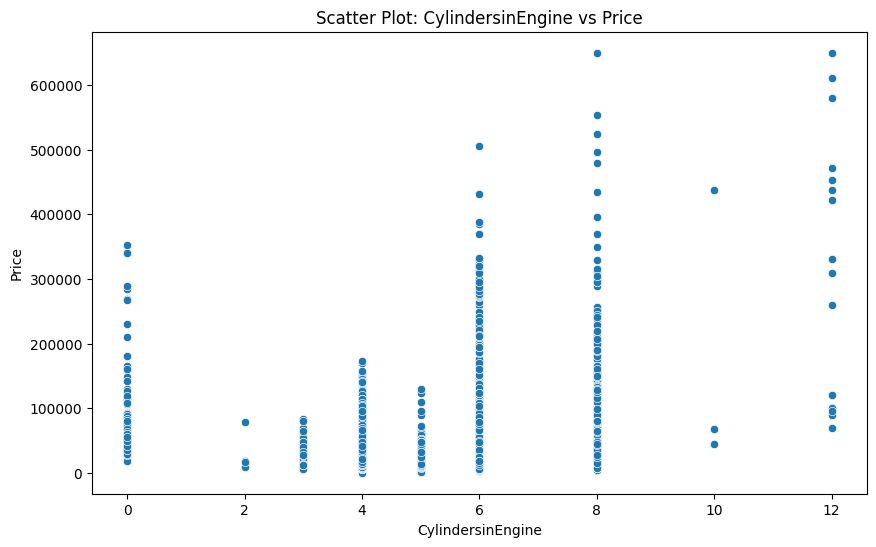

Observation for CylindersinEngine: The relationship between CylindersinEngine and 'Price' shows that cars with more cylinders tend to have higher prices, likely due to better performance or higher engine capacity.


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate the correlation matrix
corr_matrix = data.corr()
fig, ax = plt.subplots(figsize=(20, 10))
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_matrix, cmap=sns.diverging_palette(20, 220, n=200), annot=True, mask=mask, center=0)
plt.title('Correlation Matrix')
plt.show()

# Find the top 3 features that have the highest correlation with the target variable 'Price'
top_features = corr_matrix['Price'].abs().sort_values(ascending=False).index[1:4]
print("Top 3 features highly correlated with 'Price' are:", top_features[0], top_features[1], top_features[2])
print()
# Plot scatter plots for the top 3 features against 'Price'
for feature in top_features:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=data, x=feature, y='Price')
    plt.title(f'Scatter Plot: {feature} vs Price')
    plt.xlabel(feature)
    plt.ylabel('Price')
    plt.show()

    # Observations from the scatter plots
    if feature == 'Title':
        print(f"Observation for {feature}: The correlation between {feature} and 'Price' suggests that certain titles are associated with higher or lower prices, reflecting brand or model value.")
    elif feature == 'Year':
        print(f"Observation for {feature}: As {feature} increases, 'Price' tends to increase, indicating that newer cars are priced higher.")
    elif feature == 'CylindersinEngine':
        print(f"Observation for {feature}: The relationship between {feature} and 'Price' shows that cars with more cylinders tend to have higher prices, likely due to better performance or higher engine capacity.")

# <font size="5">Hyperparameter Tuning with Grid Search</font>

In [21]:
train = data.drop(columns=['Price'])
train_target = data['Price']
feature_names = train.columns.tolist()
scaler = StandardScaler()
train = scaler.fit_transform(train)
X_train, X_dev, y_train, y_dev = train_test_split(train, train_target, test_size=0.2, random_state=42)

In [22]:
# Function to perform grid search and return best model and its RMSE
def perform_grid_search(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
    grid_search.fit(X_train, y_train)
    return grid_search

In [23]:
# Define parameter grids for each model
lgb_param_grid = {
    'num_leaves': [20, 40, 60],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 150, 250],
    'reg_alpha': [0.0, 0.2, 0.4],
    'reg_lambda': [0.0, 0.2, 0.4]
}

xgb_param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 500],
    'gamma': [0,0.2, 0.4],
    'subsample': [0.6, 0.8, 1.0]
}

et_param_grid = {
    'n_estimators': [100, 200, 350],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 4, 8],
    'max_depth': [None, 20, 30]
}

In [24]:
# Perform grid search for each model
lgb_grid_search = perform_grid_search(lgb.LGBMRegressor(), lgb_param_grid, X_train, y_train)
print("Best LightGBM Parameters: ", lgb_grid_search.best_params_)
print("Best LightGBM RMSE: ", np.sqrt(np.abs(lgb_grid_search.best_score_)))

xgb_grid_search = perform_grid_search(xgb.XGBRegressor(), xgb_param_grid, X_train, y_train)
print("Best XGBoost Parameters: ", xgb_grid_search.best_params_)
print("Best XGBoost RMSE: ", np.sqrt(np.abs(xgb_grid_search.best_score_)))

et_grid_search = perform_grid_search(ExtraTreesRegressor(), et_param_grid, X_train, y_train)
print("Best ExtraTrees Parameters: ", et_grid_search.best_params_)
print("Best ExtraTrees RMSE: ", np.sqrt(np.abs(et_grid_search.best_score_)))

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best LightGBM Parameters:  {'learning_rate': 0.2, 'n_estimators': 250, 'num_leaves': 60, 'reg_alpha': 0.2, 'reg_lambda': 0.0}
Best LightGBM RMSE:  14299.4712173989
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best XGBoost Parameters:  {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.8}
Best XGBoost RMSE:  12747.247054624297
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best ExtraTrees Parameters:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best ExtraTrees RMSE:  14683.994953905009


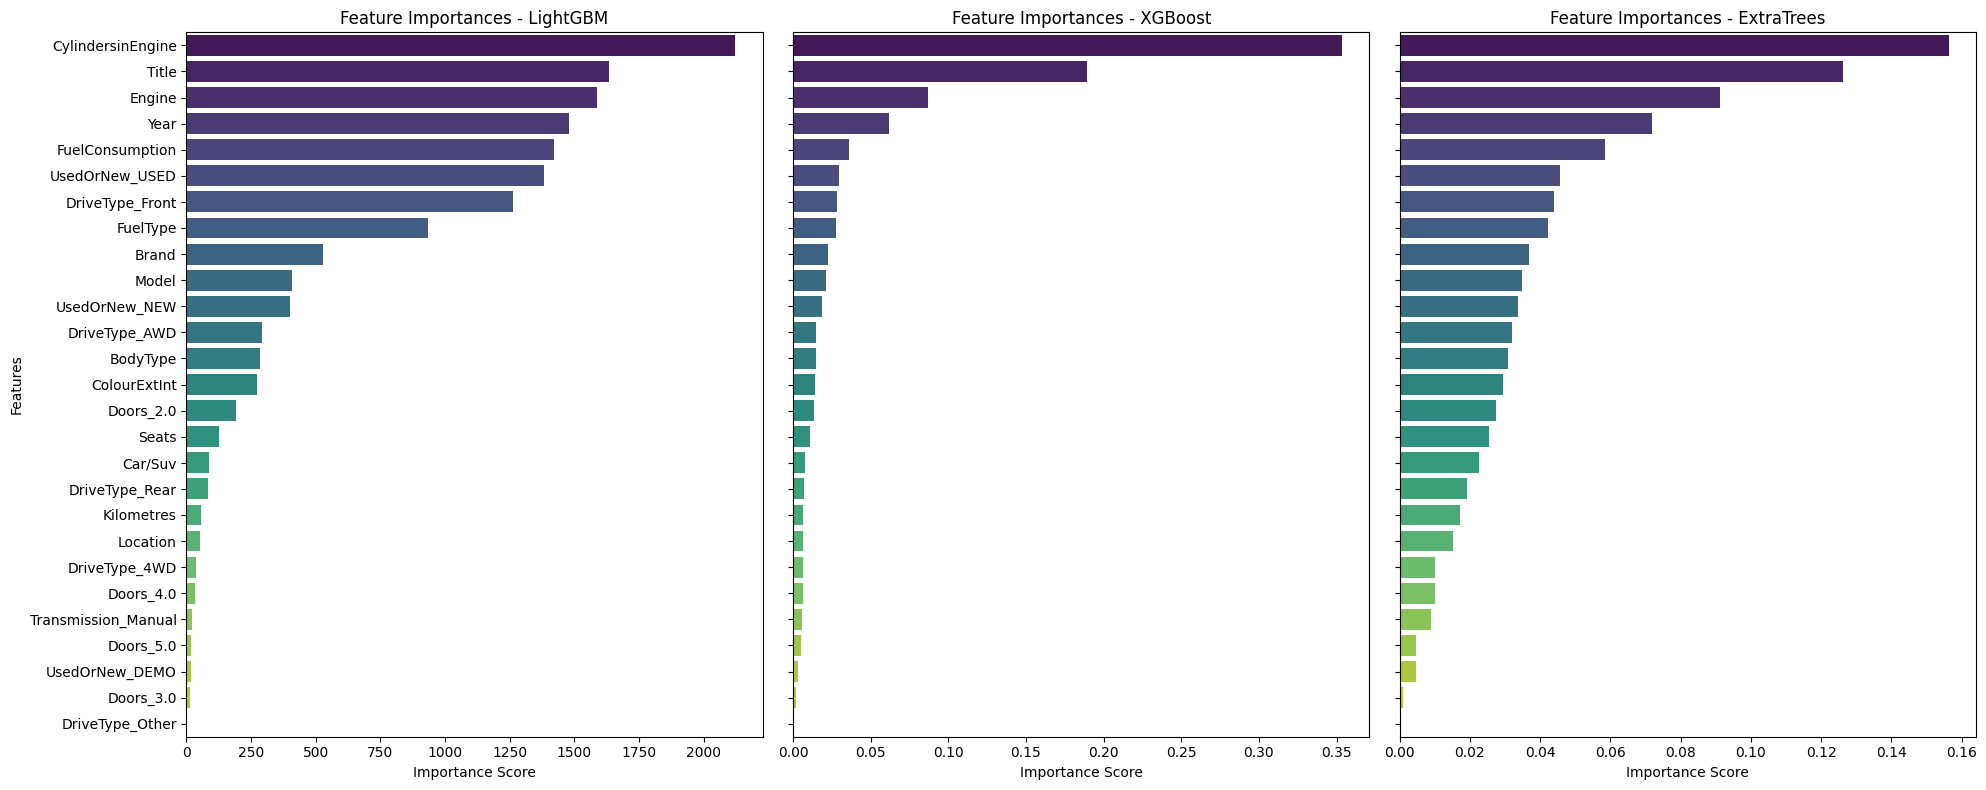

In [25]:
# Feature importance
lgb_best_model = lgb_grid_search.best_estimator_
xgb_best_model = xgb_grid_search.best_estimator_
et_best_model = et_grid_search.best_estimator_

lgb_importance = lgb_best_model.feature_importances_
xgb_importance = xgb_best_model.feature_importances_
et_importance = et_best_model.feature_importances_

# Create DataFrames to hold feature importances for each model
lgb_feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': lgb_importance
}).sort_values(by='Importance', ascending=False)

xgb_feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_importance
}).sort_values(by='Importance', ascending=False)

et_feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': et_importance
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances using seaborn on subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharey=True)

# LightGBM plot
sns.barplot(ax=axes[0], x='Importance', y='Feature', data=lgb_feature_importance_df, palette='viridis')
axes[0].set_title('Feature Importances - LightGBM')
axes[0].set_xlabel('Importance Score')
axes[0].set_ylabel('Features')

# XGBoost plot
sns.barplot(ax=axes[1], x='Importance', y='Feature', data=xgb_feature_importance_df, palette='viridis')
axes[1].set_title('Feature Importances - XGBoost')
axes[1].set_xlabel('Importance Score')
axes[1].set_ylabel('')

# ExtraTrees plot
sns.barplot(ax=axes[2], x='Importance', y='Feature', data=et_feature_importance_df, palette='viridis')
axes[2].set_title('Feature Importances - ExtraTrees')
axes[2].set_xlabel('Importance Score')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()


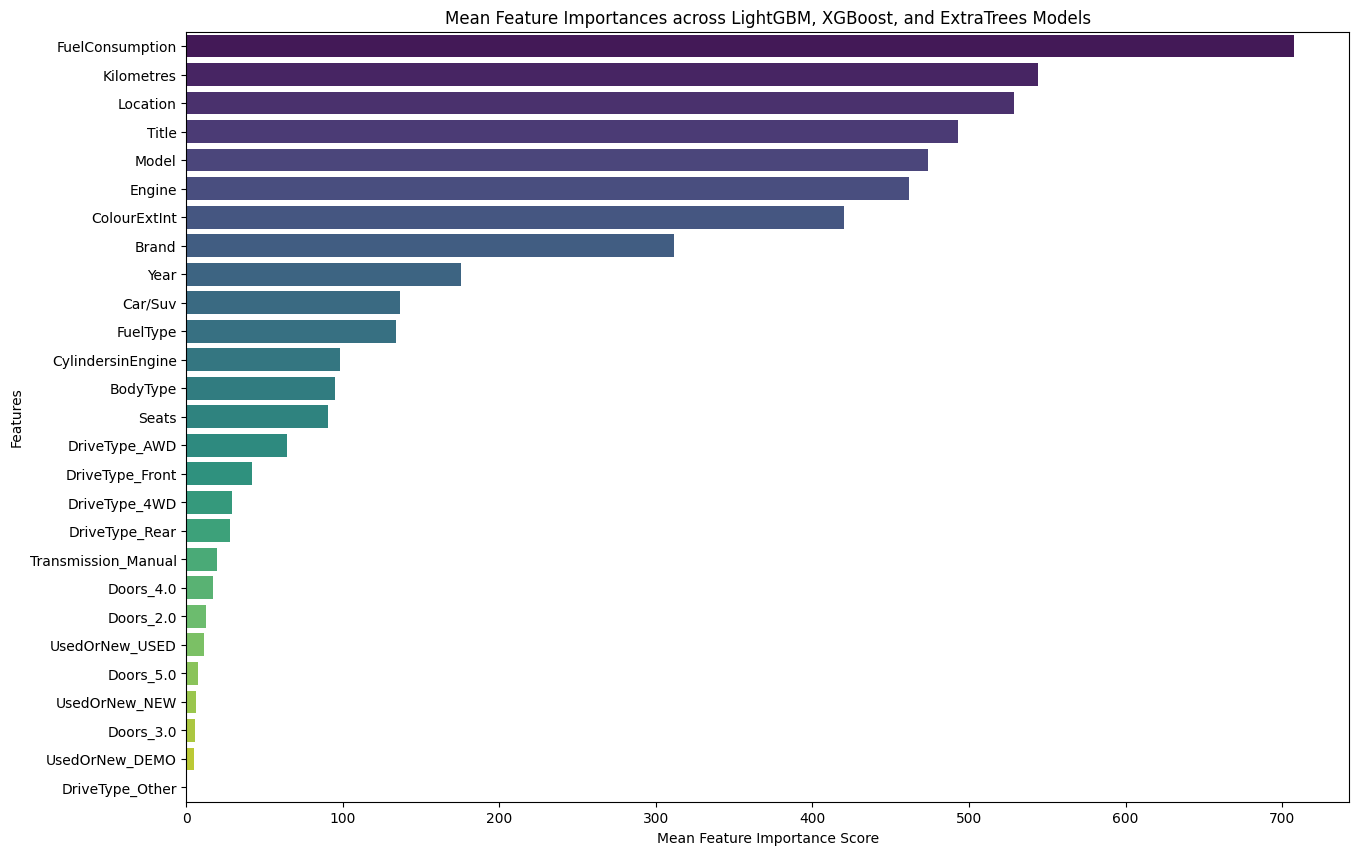

In [26]:
# Calculate mean importance across all models for each feature
mean_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean Importance': np.mean([lgb_importance, xgb_importance, et_importance], axis=0)
})

# Sort mean_importance_df by Mean Importance in descending order
mean_importance_df = mean_importance_df.sort_values(by='Mean Importance', ascending=False)

# Plot the mean feature importances using seaborn
plt.figure(figsize=(15, 10))
sns.barplot(x='Mean Importance', y='Feature', data=mean_importance_df, palette='viridis')
plt.xlabel('Mean Feature Importance Score')
plt.ylabel('Features')
plt.title('Mean Feature Importances across LightGBM, XGBoost, and ExtraTrees Models')
plt.show()


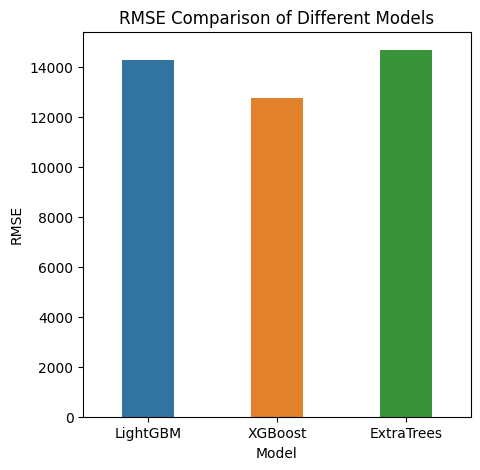

In [27]:
# Visualization of RMSE comparison
results = {
    'Model': ['LightGBM', 'XGBoost', 'ExtraTrees'],
    'RMSE': [np.sqrt(np.abs(lgb_grid_search.best_score_)), np.sqrt(np.abs(xgb_grid_search.best_score_)), np.sqrt(np.abs(et_grid_search.best_score_))]
}

results_df = pd.DataFrame(results)

plt.figure(figsize=(5, 5))
sns.barplot(x='Model', y='RMSE', data=results_df, width=0.4)
plt.title('RMSE Comparison of Different Models')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.show()